<a href="https://colab.research.google.com/github/Naval-08/deep-learning/blob/main/Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")




    

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [2]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3435, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 3435 (delta 55), reused 95 (delta 40), pack-reused 3302
Receiving objects: 100% (3435/3435), 643.59 MiB | 21.32 MiB/s, done.
Resolving deltas: 100% (1962/1962), done.
Updating files: 100% (222/222), done.


##1.Get Data


In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir=image_path/"train"
test_dir=image_path/"test"

train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2.Create Datasets and DataLoader

Using data_setup.py

### 2.1 Prepare tranforms for image

In [6]:
IMG_SIZE=224

manual_transforms=transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"Manually created transforms :{manual_transforms}")

Manually created transforms :Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


### 2.2 Turning images into dataloaders










In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f739f841eb0>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

In [9]:
len(label_batch)

32

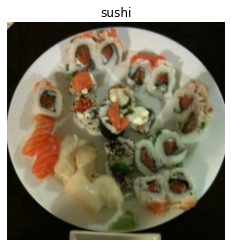

In [10]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating  ViT:Overview

 Looking at a whole machine learning research paper can be imtimidating.

So in order to make it more understandable, we can break it down into smaller pieces:

* **Inputs** - What goes into the model? (in our case, image tensors)
* **Outputs** - What comes out of the model/layer/block? (in our case, we want the model to output image classification labels)
* **Layers** - Takes an input, manipulates it with a function (for example could be self-attention).
* **Blocks**- A collection of layers.
Model (or architecture) - A collection of blocks

### 3.1 ViT overview: pieces of the puzzle

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functions of each layer/block
* Table 1/3: different hyperparameters for the architecture/training.
* Text descriptions (especially section 3.1)






### Figure 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png" width=600 alt="figure 1 from vision transformer paper"/>

* Embedding = learnable representation (start with random numbers and improve over time) 


### Four equations

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=600 alt="four equations from vision transformer paper"/>

#### Section 3.1 describes the various equations:

**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$ position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudocode:

```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
```

---



**Equations 2&3:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudocode:

```python
# Equation 2 
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3 
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block 
```
---



**Equation 4:**
Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_{L}^{0}$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = multilayer perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time 

In pseudocode:

```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block)) 
```


### Table 1 

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png" width=600 alt="table 1 from vision transformer paper"/>

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture
* ViT-B/16 = ViT-Base with image patch size 16x16 
* Layers - the number of transformer encoder layers 
* Hidden size $D$ - the embedding size throughout the architecture
* MLP size - the number of hidden units/neurons in the MLP
* Heads - the number of multi-head self-attention 


## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = input -> function -> output

What's the input shape?

What's the output shape?

* Input shape: (224, 224, 3) -> single image -> (height, width, color channels)
* Output shape: ???

### 4.1 Calculate input and output shapes by hand

> **Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

> **Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$ position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input shape: $H\times{W}\times{C}$ (height x width x color channels)
* Output shape: ${N \times\left(P^{2} \cdot C\right)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height * width) / p^2
* D = constant latent vector size = embedding dimension (see Table 1)


# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16 

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

In [11]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16 

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [12]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


###4.2 Turning a single image into patches


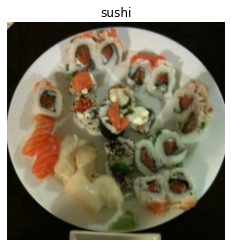

In [13]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

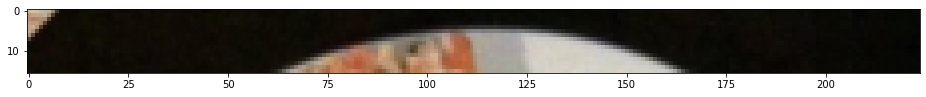

In [14]:
image_permuted = image.permute(1,2,0)

patch_size=16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size,:,:]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


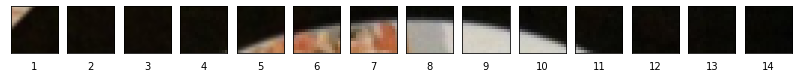

In [15]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size%patch_size==0,"Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig,axs=plt.subplots(nrows=1,
                     ncols=img_size//patch_size,
                     sharex=True,
                     sharey=True,
                     figsize=(num_patches,num_patches))

for i,patch in enumerate(range(0,img_size,patch_size)):
  axs[i].imshow(image_permuted[:patch_size,patch:patch+patch_size,:]);
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])


Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


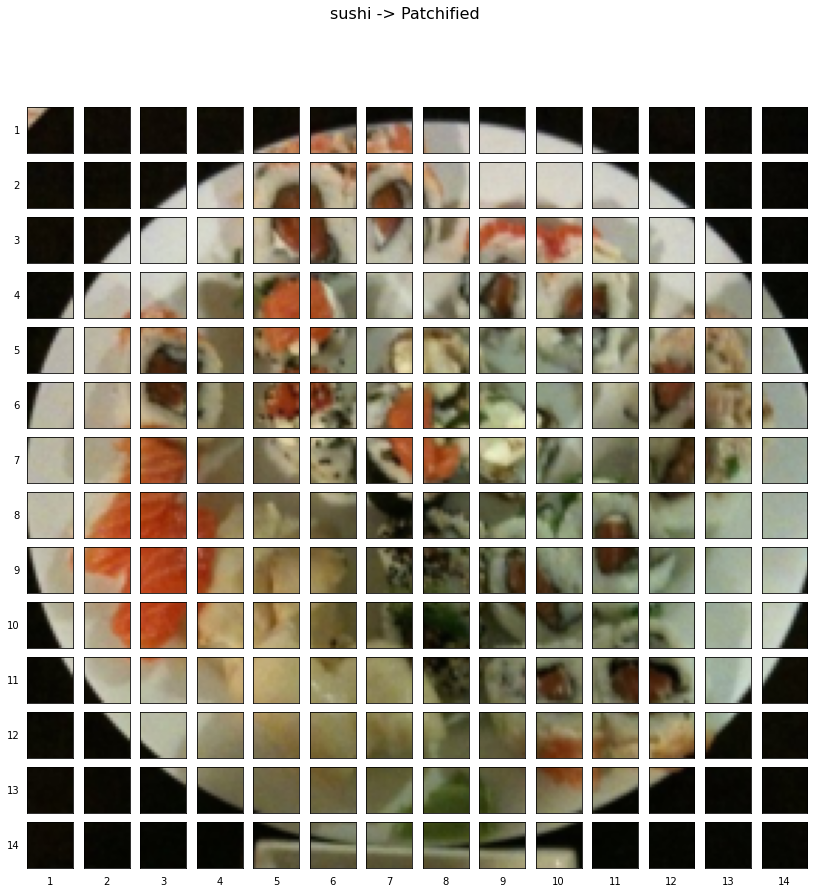

In [16]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

fig,axs=plt.subplots(nrows=img_size//patch_size,
                     ncols=img_size//patch_size,
                     figsize=(num_patches,num_patches),
                     sharex=True,
                     sharey=True)

for i,patch_height in enumerate(range(0,img_size,patch_size)):
  for j,patch_width in enumerate(range(0,img_size,patch_size)):
    axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                     patch_width:patch_width+patch_size,
                                     :])
    # Set up label information, remove the ticks for clarity and set labels to outside
    axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
    axs[i, j].set_xlabel(j+1) 
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()


### 4.3 Creating image pathes with `torch.nn.Conv2d()`

We've seen what an image looks like when it gets turned into patches, now let's start moving towards replicating the patch embedding layers with PyTorch.

To visualize our single image we wrote code to loop through the different height and width dimensions of a single image and plot individual patches.

This operation is very similar to the convolutional operation we saw in 03. PyTorch Computer Vision section 7.1: Stepping through nn.Conv2d().

In fact, the authors of the ViT paper mention in section 3.1 that the patch embedding is achievable with a convolutional neural network (CNN):

In [17]:
from torch import nn

patch_size=16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

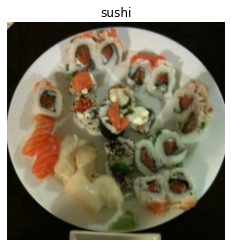

In [18]:
#view a single view
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [19]:
# pass the image to the convolution layer
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


### Now we've passed a single image to our `conv2d` layer, it's shape is:

```python

```

In [20]:
torch.Size([1, 768, 14, 14])

torch.Size([1, 768, 14, 14])

Showing random convolutional feature maps from indexes: [136, 15, 627, 655, 599]


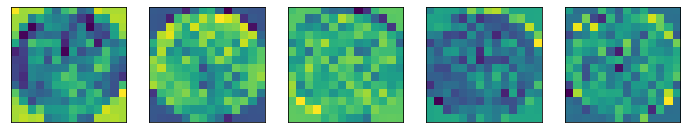

In [21]:
# plt random convolution feature maps(embeddings)
import random
random_indexes=random.sample(range(0,768),k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# create plot
fig,axs=plt.subplots(nrows=1,ncols=5,figsize=(12,12))
# plot random images feature map

for i,idx in enumerate(random_indexes):
  image_conv_feature_map=image_out_of_conv[:,idx,:,:]
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [22]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :] 
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.1255, -0.0383, -0.0290, -0.0302,  0.0367, -0.0983, -0.2802,
           -0.5055, -0.3329, -0.0037,  0.1260, -0.0303, -0.0322, -0.0263],
          [-0.0243, -0.0178, -0.1633, -0.2357, -0.1877, -0.4279, -0.1384,
           -0.3731, -0.3605, -0.4501, -0.5445,  0.0634, -0.0243, -0.0272],
          [-0.0323, -0.2220, -0.3160, -0.2994, -0.3596, -0.2315, -0.2353,
           -0.1970, -0.3271, -0.1704, -0.2108, -0.3860, -0.1556, -0.0223],
          [-0.1699, -0.2026, -0.3341, -0.1044, -0.1348, -0.1656, -0.2933,
           -0.2759, -0.1376, -0.1689, -0.1879, -0.2990, -0.3382, -0.0115],
          [-0.2046, -0.3368, -0.1400, -0.2116, -0.3002, -0.2481, -0.3218,
           -0.2763, -0.2170, -0.2761, -0.2487, -0.2881, -0.1953, -0.2820],
          [-0.2598, -0.3244, -0.2098, -0.1846, -0.1868, -0.1380, -0.1278,
           -0.0746, -0.2561, -0.2390, -0.2802, -0.0331, -0.1931, -0.3191],
          [-0.3323, -0.2434, -0.1684, -0.2068, -0.2113, -0.2959, -0.2311,
           -0.1536, -0.4604, -0.

In [23]:
# flateen the layer 
flatten_layer=nn.Flatten(start_dim=2,end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


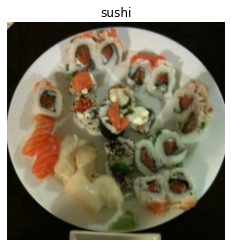

In [24]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [25]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> (batch_size, number_of_patches, embedding_dimension)")


torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


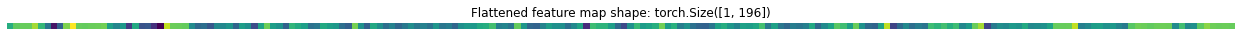

In [26]:
# get a single flattend feature map
single_flattened_feature_map=image_out_of_conv_flattened_permuted[:,:,0]

plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False); 

### 4.5 Turning the ViT patch embedding layer into a Pytorch module
We want this module to do a few things:

1. Create a class called PatchEmbedding that inherits from nn.Module.
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedded patches using nn.Conv2d().
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a foward() that defines the forward computation (e.g. pass through layer from 3 and 4).
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [27]:
class PatchEmbedding(nn.Module):
  def __init__(self,in_features:int=3,
               out_features:int=768,
               patch_size:int=16):
    super().__init__()
    self.patch_size=patch_size

    # Create a layer to turn an image into embedded  patches
    self.patcher=nn.Conv2d(in_channels=in_features,
                           out_channels=out_features,
                           kernel_size=patch_size,
                           stride=patch_size,
                           padding=0)
    
    self.flatten=nn.Flatten(start_dim=2,end_dim=3)

  def forward(self,x):
    image_resolution=x.shape[-1]
    assert image_resolution%self.patch_size==0,f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
    output=self.flatten(self.patcher(x))
    return output.permute(0,2,1)

    

In [28]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_features=3,
                          patch_size=16,
                          out_features=768)

# Pass a single image through patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [29]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

# patchify(rand_image_tensor_bad)

###4.6 Creating the class token embedding

Want to: prepend a learnable class token to the start of the patch embedding.

In [30]:
patch_embedded_image

tensor([[[ 0.0862, -0.1523, -0.0091,  ...,  0.0731, -0.2628,  0.0326],
         [-0.0653,  0.0008, -0.0383,  ...,  0.0350, -0.0243,  0.0166],
         [-0.0665, -0.0031, -0.0338,  ...,  0.0401, -0.0268,  0.0190],
         ...,
         [-0.0447, -0.0027, -0.0386,  ...,  0.0298, -0.0132,  0.0120],
         [-0.0387, -0.0028, -0.0367,  ...,  0.0245, -0.0116,  0.0131],
         [-0.0448, -0.0046, -0.0360,  ...,  0.0347, -0.0165,  0.0088]]],
       grad_fn=<PermuteBackward0>)

In [31]:
from IPython.terminal.embed import embed
# get the batch size and embeding dimension
batch_size=patch_embedded_image.shape[0]
embedding_dimension=patch_embedded_image.shape[-1]
batch_size,embedding_dimension

(1, 768)

In [32]:
class_token=nn.Parameter(torch.randn(batch_size,1,embedding_dimension),
                         requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [33]:
# Adding the class token embedding to the front of the patch embedding

patch_embedded_image_with_class_embedding=torch.cat((class_token,patch_embedded_image),
                                                    dim=1) # number of patches dimension

print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape}")

Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768])


### 4.7 Creating the positional embedding

In [34]:
number_of_patches=int((height*width)/(patch_size**2))
# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

positional_embedding=nn.Parameter(torch.ones((1,number_of_patches+1,embedding_dimension),
                                requires_grad=True))
print(positional_embedding)
positional_embedding.shape

Parameter containing:
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True)


torch.Size([1, 197, 768])

In [35]:
patch_and_positional_embedding=patch_embedded_image_with_class_embedding+positional_embedding
print(patch_and_positional_embedding)
patch_and_positional_embedding.shape

tensor([[[0.0041, 2.4136, 1.3723,  ..., 0.2121, 1.3636, 0.0814],
         [1.0862, 0.8477, 0.9909,  ..., 1.0731, 0.7372, 1.0326],
         [0.9347, 1.0008, 0.9617,  ..., 1.0350, 0.9757, 1.0166],
         ...,
         [0.9553, 0.9973, 0.9614,  ..., 1.0298, 0.9868, 1.0120],
         [0.9613, 0.9972, 0.9633,  ..., 1.0245, 0.9884, 1.0131],
         [0.9552, 0.9954, 0.9640,  ..., 1.0347, 0.9835, 1.0088]]],
       grad_fn=<AddBackward0>)


torch.Size([1, 197, 768])

### 4.8 put all together equation1

In [36]:
set_seeds()

# 1.set patch size
patch_size=16

# 2.Print shapes of the original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height,width=image.shape[1],image.shape[2]

#3. Get the tensor batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

#4.Create patch embedding layer
patch_embedding_layer=PatchEmbedding(in_features=3,out_features=768,patch_size=patch_size)

# 5.Pass image through PatchEmnedding
patch_embedding=patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 4. creating a class token
batch_Size=patch_embedding[0]
embedding_dimension=patch_embedding.shape[-1]
class_token=nn.Parameter(torch.ones((batch_size,1,embedding_dimension),
                                    requires_grad=True))
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape} ")


Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768]) 


## Equation 2: Multihead Self-Attention (MSA block)

* **Multihead self-attention** = which part of a sequence should pay the most attention to itself?
  * In our case, we have a series of embedded image patches, which patch significantly relates to another patch.
  * We want our neural network (ViT) to learn this relationship/representation.
* To replicate MSA in PyTorch we can use: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html 

* **LayerNorm** = Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
  * Normalization = make everything have the same mean and same standard deviation.
  * In PyTorch = https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html, normalizes values over $D$ dimension, in our case, the $D$ dimension is the embedding dimension. 
    * When we normalize along the embedding dimension, it's like making all of the stairs in a staircase the same size.

In [37]:
class MultiHeadSelfAttentionBlock(nn.Module): 
  """Creates a multi-head self-attention block ("MSA block" for short).
  """
  def __init__(self, 
               embedding_dim:int=768, # Hidden size D (embedding dimension) from Table 1 for ViT-Base
               num_heads:int=12, # Heads from Table 1 for ViT-Base
               attn_dropout:int=0):
    super().__init__()
    
    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create multihead attention (MSA) layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout, 
                                                batch_first=True) # is the batch first? (batch, seq, feature) -> (batch, number_of_patches, embedding_dimension)
  
  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                                         key=x,
                                         value=x,
                                         need_weights=False)
    return attn_output

In [38]:

# Create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [39]:
patched_image_through_msa_block

tensor([[[-0.1582, -0.1308,  0.0635,  ..., -0.4036,  0.8417, -0.4316],
         [-0.1293, -0.1205,  0.0701,  ..., -0.4014,  0.8546, -0.4185],
         [-0.1331, -0.1364,  0.0684,  ..., -0.3813,  0.8530, -0.4407],
         ...,
         [-0.1397, -0.1364,  0.0697,  ..., -0.3833,  0.8451, -0.4328],
         [-0.1434, -0.1368,  0.0677,  ..., -0.3827,  0.8443, -0.4315],
         [-0.1408, -0.1411,  0.0675,  ..., -0.3787,  0.8445, -0.4368]]],
       grad_fn=<TransposeBackward0>)

##6. Equation 3: Multilayer Perceptron (MLP block)

* **MLP** = The MLP contains two layers with a GELU non-linearity (section 3.1).
  * MLP = a quite broad term for a block with a series of layer(s), layers can be multiple or even only one hidden layer. 
  * Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing. In PyTorch, they're often called `torch.nn.Linear()` and in TensorFlow they might be called `tf.keras.layers.Dense()`
  * GELU in PyTorch - https://pytorch.org/docs/stable/generated/torch.nn.GELU.html#torch.nn.GELU 
  * MLP number of hidden units = MLP Size in Table 1
* **Dropout** =  Dropout, when used, is applied after
every dense layer except for the the qkv-projections and directly after adding positional- to patch
embeddings. Hybrid models are trained with the exact setup as their ViT counterparts. 
  * Value for Dropout available in Table 3 

In pseudocode:

```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```

In [40]:
class MLPBlock(nn.Module):
  
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:int=0.1):
    super().__init__()

    # creating a normal layer
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    # create the MLP
    self.mlp=nn.Sequential(
      nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
      nn.GELU(),
      nn.Dropout(p=dropout),
      nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
      nn.Dropout(p=dropout) )

  def forward(self, x):
    x = self.layer_norm(x) 
    x = self.mlp(x)
    return x


In [41]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output the MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


## 7. Creating the Transformer Encoder

The Transformer Encoder is a combination of alternating blocks of MSA (equation 2) and MLP (equation 3).

And there are residual connections between each block.

* Encoder = turn a sequence into learnable representation
* Decoder = go from learn representation back to some sort of sequence
* Residual connections = add a layer(s) input to its subsequent output, this enables the creation of deeper networks (prevents weights from getting too small)

In pseudocode:

```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ... 
```

In [42]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768, # Hidden size D from table 1, 768 for ViT-Base
               num_heads:int=12, # from table 1
               mlp_size:int=3072, # from table 1
               mlp_dropout:int=0.1, # from table 3
               attn_dropout:int=0):
    super().__init__()

    # Create MSA block (equation 2)
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)
    
    # Create MLP block (equation 3)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim, 
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)
    
  def forward(self, x):
    x = self.msa_block(x) + x # residual/skip connection for equation 2
    x = self.mlp_block(x) + x # residual/skip connection for equation 3
    return x 

In [43]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Create a Transformer Encoder layer with in-built PyTorch layers

So far we've created a transformer encoder by hand.

But because of how good the Transformer architecture is, PyTorch has implemented ready to use Transformer Encoder layers: https://pytorch.org/docs/stable/nn.html#transformer-layers 

We can create a Transformer Encoder with pure PyTorch layers: https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer 

In [44]:
torch_transformer_encoder_layer=nn.TransformerEncoderLayer(
  d_model=768,
  nhead=12,
  dim_feedforward=3072,
  dropout=0.1,
  batch_first=True,
  norm_first=True,
  activation="gelu"  
)

In [45]:
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [46]:
# Get a summary using torchinfo.summary
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## 8.Putting it all together to create ViT

In [47]:
class ViT(nn.Module):

  def __init__(self,
               img_size:int=224,
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12,
               embedding_dim:int=768,
               mlp_size:int=3072,
               num_heads:int=12,
               attn_dropout:int=0,
               mlp_dropout:int=0.1,
               embedding_dropout:int=0.1,
               num_classes:int=100
               ):
    super().__init__()
    assert img_size % patch_size==0,f"Image sie must be divisible by patch size,image:{img_size}, patch size:{patch_size}"

    self.num_patches=(img_size*img_size)//patch_size**2

    # create learnable class embedding
    self.class_embedding=nn.Parameter(data=torch.randn(1,1,embedding_dim),requires_grad=True)
    # create learnable positional embedding
    self.positional_embedding=nn.Parameter(data=torch.randn(1,self.num_patches+1,embedding_dim),
                                            requires_grad=True)
    # creatinf ebedding dropout
    self.embedding_dropout=nn.Dropout(p=embedding_dropout)

    # create patch embedding layer
    self.patch_embedding=PatchEmbedding(in_features=in_channels,
                                        patch_size=patch_size,
                                        out_features=embedding_dim
                                        )
    # create the transformer encoder block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
    # create mlp head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self,x):
    batch_size = x.shape[0]
    class_token=self.class_embedding.expand(batch_size,-1,-1)
    x=self.patch_embedding(x)
    x = torch.cat((class_token,x),dim=1)
    x = self.positional_embedding+x
    x = self.embedding_dropout(x)
    x = self.transformer_encoder(x)
    x = self.classifier(x[:,0])
    return x






In [48]:
batch_size=32
embedding_dim=768

class_embedding = nn.Parameter(data=torch.randn(1,1,embedding_dim),requires_grad=True)

class_embedding_expanded = class_embedding.expand(batch_size,-1,-1)

print(class_embedding.shape)
print(class_embedding_expanded.shape)

torch.Size([1, 1, 768])
torch.Size([32, 1, 768])


In [49]:
set_seeds()
random_image_tensor =torch.randn(1,3,224,224)

vit = ViT(num_classes=len(class_names))

vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [50]:
from torchinfo import summary

summary(model=ViT(num_classes=len(class_names)),
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

In [51]:
# Number of parameters in pretrained ViT
num_params = 85,800,963
num_params

(85, 800, 963)

## 9. Setting up training code for our custom ViT

We've replicated the ViT architecture, now let's see how it performs on our FoodVision Mini data.

### 9.1 Creating an optimizer

The paper states it uses the Adam optimizer (section 4, Training & fine-tuning) with $B1$ value of 0.9, $B2$ of 0.999 (defaults) and a weight decay of 0.1.

Weight decay = Weight decay is a regularization technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function. 

Regularization technique = prevents overfitting.

### 9.2 Creating a loss function

The ViT paper doesn't actually mention what loss function they used.

So since it's a multi-class classification we'll use the `torch.nn.CrossEntropyLoss()`.

In [52]:
from going_modular.going_modular import engine

set_seeds()

optimizer = torch.optim.Adam(vit.parameters(), 
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.8769 | train_acc: 0.3008 | test_loss: 1.0393 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.5149 | train_acc: 0.3047 | test_loss: 1.5086 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.4133 | train_acc: 0.2617 | test_loss: 1.4602 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.2590 | train_acc: 0.4102 | test_loss: 1.9580 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3003 | train_acc: 0.2812 | test_loss: 1.6453 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.2523 | train_acc: 0.2969 | test_loss: 1.7505 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1795 | train_acc: 0.4102 | test_loss: 3.2499 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.4590 | train_acc: 0.2852 | test_loss: 1.3793 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.3395 | train_acc: 0.3672 | test_loss: 1.2891 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.4096 | train_acc: 0.3164 | test_loss: 1.3273 | test_acc: 0.2604


In [53]:
device

'cuda'

### 9.4 What our training setup is missing

How is our training setup different to the ViT paper? 

We've replicated model archirecture correctly.

But what was different between our training procedure (to get such poor results) and the ViT paper training procedure to get such great results?

The main things our training implementation is missing: 

Prevent underfitting:
* Data - our setup uses far less data (225 vs millions)

Prevent overfitting: 
* Learning rate warmup - start with a low learning rate and increase to a base LR
* Learning rate decay - as your model gets closer to convergence, start to lower the learning rate 
* Gradient clipping - prevent gradients from getting too big 

Search "pytorch [technique name]" 



```
# This is formatted as code
```

### 9.5 Plotting loss curves for our model

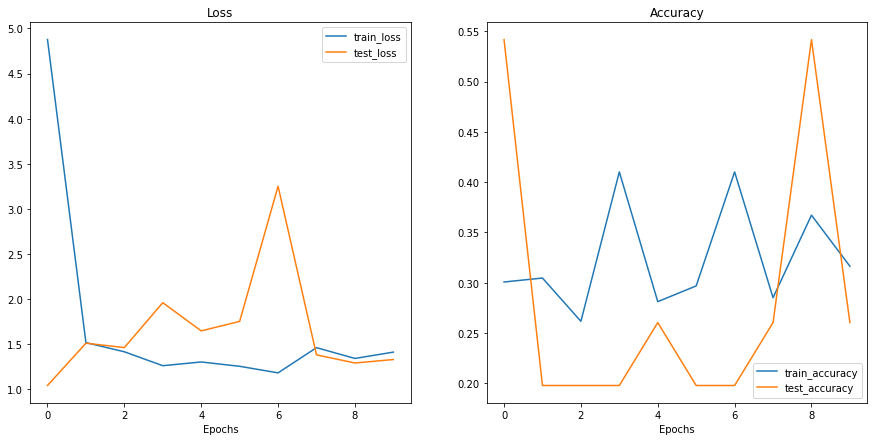

In [54]:
from helper_functions import plot_loss_curves

plot_loss_curves(results) 


## 10. Using a pretrained ViT from `torchvision.models`

Generally, in deep learning if you can use a pretrained model from a large dataset on your own problem, it's often a good place to start.

If you can find a pretrained model and use transfer learning, give it a go, it often achieves great results with little data.

### 10.1 Why use a pretrained model?

* Sometimes data is limited
* Limited training resources
* Get better results faster (sometimes)...

### 10.2 Prepare a pretrained ViT for use with FoodVision Mini (turn it into a feature extractor)

In [56]:
# get pretrained weights for Vit-Base

pretrained_vit_weights=torchvision.models.ViT_B_16_Weights.DEFAULT

# setup a vit model instance pretrained weights
pretrained_vit= torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

for param in pretrained_vit.parameters():
  param.requires_grad=False

# update the classifier head
set_seeds()
pretrained_vit.heads=nn.Linear(in_features=768,out_features=len(class_names))


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [57]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 10.3 Preparing data for the pretrained ViT model

When using a pretrained model, you want to make sure your data is formatted in the same way that the model was trained on. 

In [59]:
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [60]:
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [61]:
# Setup dataloaders
from going_modular.going_modular import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32) # could set a higher batch size because using a pretrained model 

### 10.4 Train feature extractor ViT model

In [63]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)

los_fn = torch.nn.CrossEntropyLoss()
set_seeds()
pretrained_vit_results=engine.train(
    model=pretrained_vit,
    train_dataloader=train_dataloader_pretrained,
    test_dataloader=test_dataloader_pretrained,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7665 | train_acc: 0.7227 | test_loss: 0.5432 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.3428 | train_acc: 0.9453 | test_loss: 0.3263 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2064 | train_acc: 0.9531 | test_loss: 0.2707 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.1556 | train_acc: 0.9570 | test_loss: 0.2422 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.1246 | train_acc: 0.9727 | test_loss: 0.2279 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1216 | train_acc: 0.9766 | test_loss: 0.2129 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0938 | train_acc: 0.9766 | test_loss: 0.2352 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0797 | train_acc: 0.9844 | test_loss: 0.2281 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.1098 | train_acc: 0.9883 | test_loss: 0.2074 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0650 | train_acc: 0.9883 | test_loss: 0.1804 | test_acc: 0.9176


### 10.5 Plot the loss curves of our pretrained ViT feature extractor model

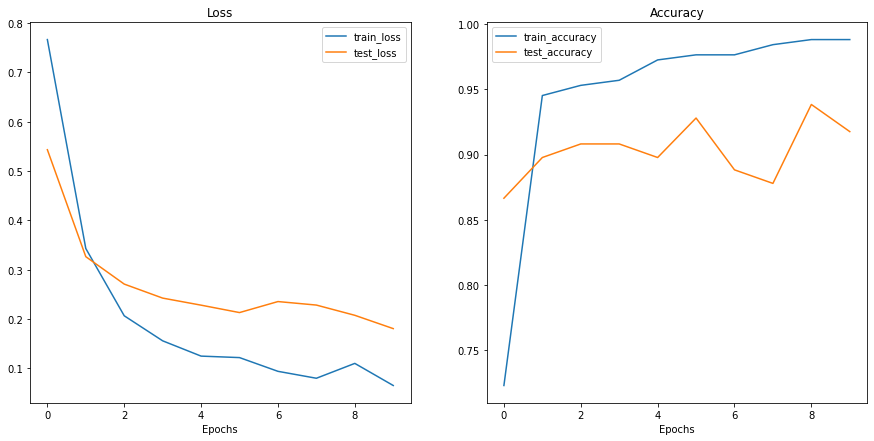

In [65]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### 10.6 Save our best performing ViT model

Now we've got a model that performs quite well, how about we save it to file and then check it's filesize.

We want to check the filesize because if we wanted to deploy a model to say a website/mobile application, we may limitations on the size of the model we can deploy.

E.g. a smaller model may be required due to compute restrictions.

In [67]:
# save the model

from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [71]:
from pathlib import Path

pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size//(1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size}MB")

Pretrained ViT feature extractor model size: 327MB


## 11. Predicting on a custom image

Downloading..


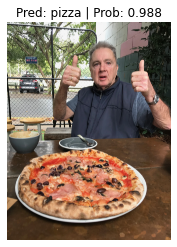

In [75]:
import requests

from going_modular.going_modular.predictions import pred_and_plot_image

custom_image_path = image_path/"predict.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path,"wb") as f:
    request = requests.get("")
    print("Downloading..")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download.")

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)
